## Final Project Submission

Please fill out:
* Student name: Abdulrahman Aber, Benjamin Bai, Charles Pan, Kevin Rivera
* Student pace: Full Time
* Scheduled project review date/time: 
* Instructor name: David Elliott
* Blog post URL:


# Imports, Data Frame Initializations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3 as sq
import seaborn as sns
import statistics as st
import datetime
conn = sq.connect('./zippedData/im.db')
cur = conn.cursor()

In [2]:
movie_basics_df = pd.read_sql('''select * from movie_basics''', conn)

In [3]:
movie_ratings_df = pd.read_sql("""select * from movie_ratings""",conn)

In [4]:
persons_df = pd.read_sql("""select * from persons""",conn)

In [5]:
principals_df = pd.read_sql("""select * from principals""",conn)

In [6]:
tmdb_movies_df = pd.read_csv('./zippedData/tmdb.movies.csv.gz')

In [7]:
tn_movie_budgets_df = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz',
                                 parse_dates=['release_date'])

In [8]:
tn_movie_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   object        
 4   domestic_gross     5782 non-null   object        
 5   worldwide_gross    5782 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 271.2+ KB


tn_movie_budgets_df.info() shows us that this dataframe will be used to derive net_return and ROI as a percentage, specifically production_budget and worldwide_gross. We believe net_return and ROI% are the key metrics for an executive team weighing different investment options. 

# TN Movie Budgets Clean Up Process (Genres Analysis)

In [9]:
# Remove $ from production_budget, convert to float
tn_movie_budgets_df['production_budget'] = tn_movie_budgets_df['production_budget'].str.replace(',', '').str.replace('$', '').astype(float)

# Remove $ from domestic_gross, convert to float
tn_movie_budgets_df['domestic_gross'] = tn_movie_budgets_df['domestic_gross'].str.replace(',', '').str.replace('$', '').astype(float)

# Remove $ from worldwide_gross, convert to float
tn_movie_budgets_df['worldwide_gross'] = tn_movie_budgets_df['worldwide_gross'].str.replace(',', '').str.replace('$', '').astype(float)

# new column release_year from release_date to filter based on time frame in scope
tn_movie_budgets_df['release_year'] = pd.DatetimeIndex(tn_movie_budgets_df['release_date']).year

# time frame: 2010-Present; SAG definition of theatrical budget: > 2 million
tn_movie_budgets_df = tn_movie_budgets_df[(tn_movie_budgets_df.release_year >= 2010) & (tn_movie_budgets_df.production_budget > 1999999)]

# Recommendation 1: Genres Analysis
TN Movie Budgets merge with IMDB Movie Basics to compare net return and ROI percent

In [10]:
# rename movie_basics column to match tn_movie_budgets
movie_basics_df.rename(columns={"primary_title":"movie"}, inplace = True)

# merge movie_budgets and imdb movie_basics
moviebudgets_moviebasics_df = tn_movie_budgets_df.merge(movie_basics_df, how='inner', on='movie')

# drop columns that are not relevant to Genre analysis
moviebudgets_moviebasics_df.drop(columns = ['id', 'movie_id', 'original_title', 'runtime_minutes', 'domestic_gross' ],axis=1,inplace=True)

# remove duplicate movies
moviebudgets_moviebasics_df.drop_duplicates(subset='movie', keep='last', inplace=True, ignore_index=False)

# add column for net_return
moviebudgets_moviebasics_df['net_return'] = (moviebudgets_moviebasics_df['worldwide_gross'] - moviebudgets_moviebasics_df['production_budget'])

# add column for ROI as a %
moviebudgets_moviebasics_df['roi_percent'] = ((moviebudgets_moviebasics_df['net_return'] / moviebudgets_moviebasics_df['production_budget'])*100)

In [11]:
moviebudgets_moviebasics_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1530 entries, 0 to 2215
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       1530 non-null   datetime64[ns]
 1   movie              1530 non-null   object        
 2   production_budget  1530 non-null   float64       
 3   worldwide_gross    1530 non-null   float64       
 4   release_year       1530 non-null   int64         
 5   start_year         1530 non-null   int64         
 6   genres             1520 non-null   object        
 7   net_return         1530 non-null   float64       
 8   roi_percent        1530 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 119.5+ KB


Our sample size is 3733 Unique Films since 2010 to perform Genres Analysis on and after the cleanup process, we now have all the data we need to compare net_return and ROI percent across these films to best inform our recommendation for the executive team at Microsoft

# Recommendation 1: Visualizations

In [12]:
# genres to list 
moviebudgets_moviebasics_df['genres'] = moviebudgets_moviebasics_df['genres'].str.split(",")
# explode out rows for movies with multiple genres for visualization purposes
moviebudgets_moviebasics_df = moviebudgets_moviebasics_df.explode('genres')
# means grouped by genre
moviebudgets_moviebasics_mean_df = moviebudgets_moviebasics_df.groupby(['genres']).mean().reset_index()

In [13]:
# visualization 1: initialize relevant dataframes and lists for x/y values
netreturn_vis = moviebudgets_moviebasics_df.dropna()

n_list = list(moviebudgets_moviebasics_df['genres'].value_counts().head(10).keys())

netreturn_vis = netreturn_vis[netreturn_vis['genres'].isin(n_list)]

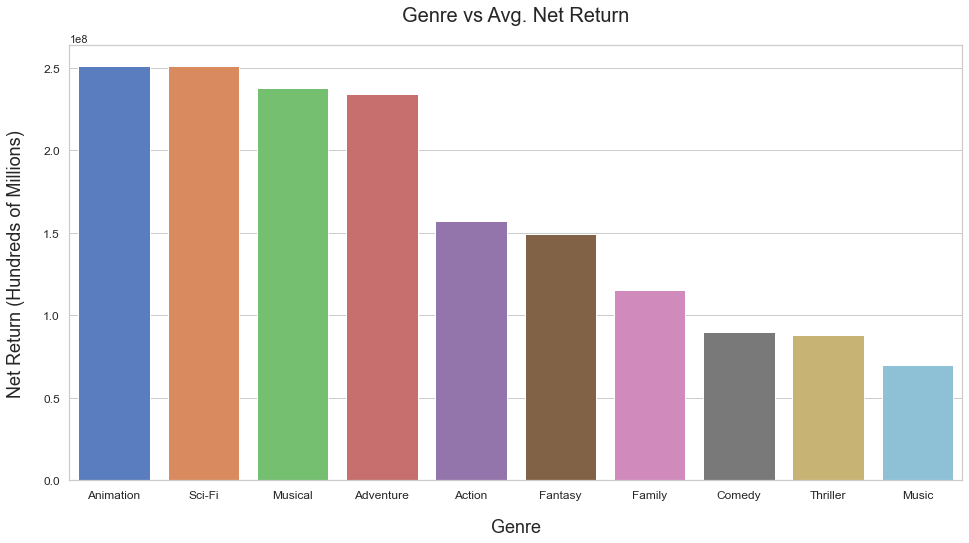

In [14]:
# visualization 1: net return bar plot

# seaborn style
sns.set(style='whitegrid')

# initialize matlab plot
fig, ax = plt.subplots(figsize=(16, 8))

# define df, x and y values
roi_vis = moviebudgets_moviebasics_mean_df.sort_values(by='net_return', ascending=False).head(10)
x_values = list(roi_vis['genres'])
y_values = list(roi_vis['net_return'])

net_return_vis = moviebudgets_moviebasics_mean_df.sort_values(by='net_return', ascending=False).head(10)

sns.barplot(x=x_values, y=y_values, data=roi_vis, palette='muted')
ax.set_title('Genre vs Avg. Net Return', fontsize = 20, pad=24)
plt.xlabel('Genre', fontsize = 18, labelpad=18)
plt.ylabel('Net Return (Hundreds of Millions)', fontsize = 18, labelpad=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('net_return_visualization.png', bbox_inches='tight')

# Visualization 1 - Net Return Observations
This chart shows that the top 3 earning genres of film in terms of Net Return (Worldwide Gross - Production Budget) are Animation, Sci-Fi, and Musical/Adventure.

In addition, all of the top 20 Adventure films in terms of net return are sequels or have since produced sequels (Frozen, Zootopia) of existing, and already widely popular intellectual property (Marvel, James Bond, Jumanji, etc.). This informs our recommendation in that it suggests that the average return for a standalone adventure film is significantly less than what the average suggests. 

Since acquiring highly popular IP or producing sequels to existing IP is a difficult hurdle for a brand new studio to overcome, we do not recommend that the proposed Microsoft Film Studios produce an Action/Adventure blockbuster type of film as one of its first ventures into the industry.

In [15]:
moviebudgets_moviebasics_df[moviebudgets_moviebasics_df['genres'] == 'Adventure'].sort_values(by='net_return', ascending=False).head(20)

,release_date,movie,production_budget,worldwide_gross,release_year,start_year,genres,net_return,roi_percent
3,2018-04-27,Avengers: Infinity War,300000000.0,2.048134e+09,2018,2018,Adventure,1.748134e+09,582.711400
23,2015-06-12,Jurassic World,215000000.0,1.648855e+09,2015,2015,Adventure,1.433855e+09,666.909239
18,2012-05-04,The Avengers,225000000.0,1.517936e+09,2012,2012,Adventure,1.292936e+09,574.638176
36,2018-02-16,Black Panther,200000000.0,1.348258e+09,2018,2018,Adventure,1.148258e+09,574.129112
99,2018-06-22,Jurassic World: Fallen Kingdom,170000000.0,1.305773e+09,2018,2018,Adventure,1.135773e+09,668.101646
137,2013-11-22,Frozen,150000000.0,1.272470e+09,2013,2013,Adventure,1.122470e+09,748.313273
396,2015-07-10,Minions,74000000.0,1.160336e+09,2015,2015,Adventure,1.086336e+09,1468.021855
2,2015-05-01,Avengers: Age of Ultron,330600000.0,1.403014e+09,2015,2015,Adventure,1.072414e+09,324.384139
37,2018-06-15,Incredibles 2,200000000.0,1.242521e+09,2018,2018,Adventure,1.042521e+09,521.260356
41,2013-05-03,Iron Man 3,200000000.0,1.215392e+09,2013,2013,Adventure,1.015392e+09,507.696136


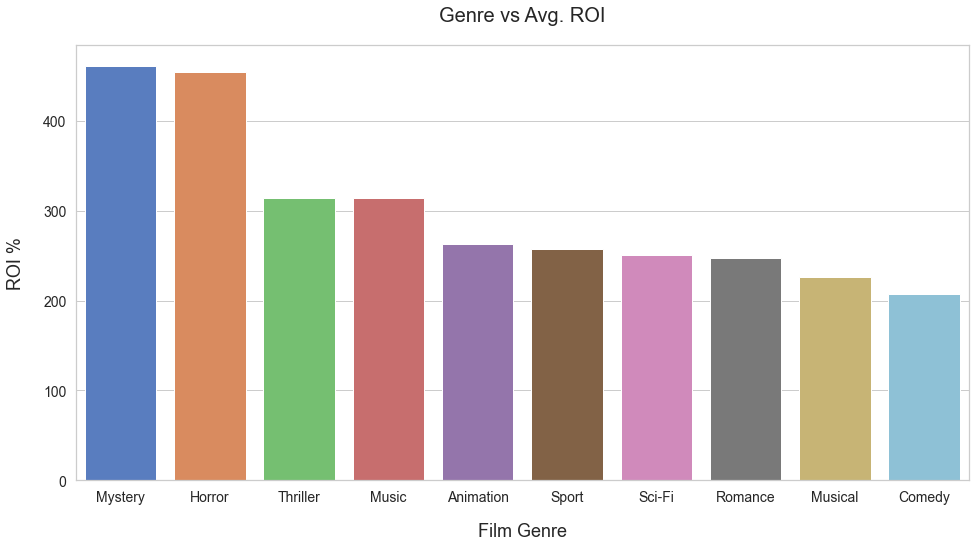

In [16]:
# visualization 2: ROI% bar plot

# seaborn style
sns.set(style='whitegrid')

# initialize matlab plot
fig, ax = plt.subplots(figsize=(16, 8))

# define df, x and y values
roi_vis = moviebudgets_moviebasics_mean_df.sort_values(by='roi_percent', ascending=False).head(10)
x_values = list(roi_vis['genres'])
y_values = list(roi_vis['roi_percent'])

# plot
sns.barplot(x=x_values, y=y_values,  data=roi_vis, palette='muted')
ax.set_title('Genre vs Avg. ROI', fontsize = 20, pad=24)
plt.xlabel('Film Genre', fontsize = 18, labelpad=18)
plt.ylabel('ROI %',  fontsize = 18, labelpad=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('roi_percent_visualization.png', bbox_inches='tight')

# Visualization 2 - Net Return Observations
Figure 2 shows that the genres with the highest ROI% are Mystery, Horror, and Thriller films with Mystery/Horror films returning 400% of the initial investment on average. 

This suggests that the production budgets for horror films on average are on the lower end of the spectrum, and offer studios the best bang for their buck. As such, our recommendation is that Microsoft Studios start out by producing Horror movies with relatively lower production budgets as a way to manage risk and maximize ROI%.

In [17]:
moviebudgets_moviebasics_df[moviebudgets_moviebasics_df['genres'] == 'Horror'].sort_values(by='net_return', ascending=False).head(20)

,release_date,movie,production_budget,worldwide_gross,release_year,start_year,genres,net_return,roi_percent
770,2017-09-08,It,35000000.0,697457969.0,2017,2017,Horror,662457969.0,1892.737054
95,2017-11-22,Coco,175000000.0,798008101.0,2017,2017,Horror,623008101.0,356.004629
168,2015-12-25,The Revenant,135000000.0,532938302.0,2015,2012,Horror,397938302.0,294.769113
78,2018-08-10,The Meg,178000000.0,529530715.0,2018,2018,Horror,351530715.0,197.489166
58,2013-06-21,World War Z,190000000.0,531514650.0,2013,2013,Horror,341514650.0,179.744553
1310,2018-04-06,A Quiet Place,17000000.0,334522294.0,2018,2018,Horror,317522294.0,1867.778200
1152,2013-07-19,The Conjuring,20000000.0,318000141.0,2013,2013,Horror,298000141.0,1490.000705
1355,2017-08-11,Annabelle: Creation,15000000.0,305384865.0,2017,2017,Horror,290384865.0,1935.899100
700,2017-01-27,Resident Evil: The Final Chapter,40000000.0,314101190.0,2017,2016,Horror,274101190.0,685.252975
385,2013-05-31,Now You See Me,75000000.0,342769200.0,2013,2012,Horror,267769200.0,357.025600


# TN Movie Budgets Clean Up Process (Release Date Analysis)

In [18]:

tn_movies = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')
                                
#Get rid of punctuation on worldwide_gross column
tn_movies['worldwide_gross'] = tn_movies['worldwide_gross'].replace('[\$,]', '', regex=True)

#Get rid of punctuation on domestic_gross column
tn_movies['domestic_gross'] = tn_movies['domestic_gross'].replace('[\$,]', '', regex=True)

#Get rid of punctuation on production_budget column
tn_movies['production_budget'] = tn_movies['production_budget'].replace('[\$,]', '', regex=True)

#change worldwide_gross column to float
tn_movies['worldwide_gross'] = tn_movies['worldwide_gross'].astype(float)

#change domestic_gross column to int
tn_movies['domestic_gross'] = tn_movies['domestic_gross'].astype(int)

#change production_budget column to int
tn_movies['production_budget']=tn_movies['production_budget'].astype(int)

In [19]:
tn_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5782 non-null   int64  
 1   release_date       5782 non-null   object 
 2   movie              5782 non-null   object 
 3   production_budget  5782 non-null   int32  
 4   domestic_gross     5782 non-null   int32  
 5   worldwide_gross    5782 non-null   float64
dtypes: float64(1), int32(2), int64(1), object(2)
memory usage: 226.0+ KB


As shown above, all of the fields are now the correct data type.

# Recommendation 2: Release Month Analysis

With this recommendation we decided to use the return on investment(ROI) percentage to see if there was a trend in getting more ROI from releasing a movie in a certain month.
The process that was used to get this percentage was taking the worldwide gross column minus production budget to get net income, then dividing net income by production budget to end up with an ROI percentage

In [20]:
#create a net_income column by taking domestic_gross and subtracting production budget
tn_movies["net_return"]=tn_movies['worldwide_gross']-tn_movies['production_budget']

#create a cost_revenue_ratio by taking net income and dividing it by production budget
tn_movies["ROI"]=((tn_movies['net_return'])/(tn_movies['production_budget']))*100

#change all cost_rev values into int 
tn_movies["ROI"] =tn_movies["ROI"].astype(int)

#change release_date column into datetime format
tn_movies["release_date"] = pd.to_datetime(tn_movies["release_date"])

#create a month and year column
tn_movies['year'] = pd.DatetimeIndex(tn_movies['release_date']).year
tn_movies['month'] = pd.DatetimeIndex(tn_movies['release_date']).month

# time frame: 2010-Present & SAG definition of theatrical budget: > 2 million
tn_movies_2010 = tn_movies[(tn_movies['production_budget'] > 1999999) & (tn_movies['year'] >= 2010)]

In [21]:
tn_movies_2010.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1851 entries, 1 to 5000
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 1851 non-null   int64         
 1   release_date       1851 non-null   datetime64[ns]
 2   movie              1851 non-null   object        
 3   production_budget  1851 non-null   int32         
 4   domestic_gross     1851 non-null   int32         
 5   worldwide_gross    1851 non-null   float64       
 6   net_return         1851 non-null   float64       
 7   ROI                1851 non-null   int32         
 8   year               1851 non-null   int64         
 9   month              1851 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int32(3), int64(3), object(1)
memory usage: 137.4+ KB


Our sample size is 1851 unique films released since 2010 that also has a production budget of $2 million or more (SAG definition of a theatrical movie). Net Return and ROI were added to allow for meaningful comparison among the films

# Recommendation 2: Month Release Visualization

In [22]:
#created a list with all the Cost_Rev_Ratios in tn_movies_2010
ROI = [x for x in tn_movies_2010["ROI"]] 
#created a list of all the month value associated with each cost_rev_ratio
Month = [x for x in tn_movies_2010['month']]
#mapped both list into a master list as tuples
ROI_Month = list(map(lambda *x: x, Month, ROI))
#created a function that would take in associated number and append a new list of Cost_Rev_Ratio based on associated month value
#get the mean of the list by associated month  
def month_mean(num):
    x = []
    for index, tuple in enumerate(ROI_Month):
        element_one = tuple[0]
        element_two = tuple[1]
        if element_one == num:
            x.append(element_two)
    return(st.mean(x))
#created a function that would take in associated number and append a new list of Cost_Rev_Ratio based on associated month value
#get the median of the list by associated month 
def month_median(num):
    x = []
    for index, tuple in enumerate(ROI_Month):
        element_one = tuple[0]
        element_two = tuple[1]
        if element_one == num:
            x.append(element_two)
    return(st.median(x))

In [23]:
#created dictionary to map month_index to month_list
month_index = [1,2,3,4,5,6,7,8,9,10,11,12]
month_list = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']
mapped_months = dict(map(lambda *x: x, month_index, month_list))

In [24]:
#made two list using functions above of all medians per month and means per month 
by_month_mean_list = []
by_month_median_list = []
for num in mapped_months.keys():
    by_month_mean_list.append(month_mean(num))
    by_month_median_list.append(month_median(num))

In [25]:
#created two dictionaries that mapped values of the two list above to associated month 
month_mean = dict(map(lambda *x: x, month_list, by_month_mean_list))
month_median = dict(map(lambda *x: x, month_list, by_month_median_list))

In [26]:
month_mean

{'Jan': 242.28571428571428,
 'Feb': 215.30714285714285,
 'Mar': 151.95209580838323,
 'Apr': 156.03947368421052,
 'May': 211.47058823529412,
 'June': 234.1631205673759,
 'July': 288.6136363636364,
 'Aug': 194.85034013605443,
 'Sept': 159.99397590361446,
 'Oct': 270.6309523809524,
 'Nov': 233.86335403726707,
 'Dec': 136.70697674418605}

In [27]:
month_median

{'Jan': 76.0,
 'Feb': 98.5,
 'Mar': 77,
 'Apr': 66.0,
 'May': 127.0,
 'June': 103,
 'July': 167.5,
 'Aug': 94,
 'Sept': 67.0,
 'Oct': 50.0,
 'Nov': 125,
 'Dec': 72}

The medians are lower than the averages, which shows a positive skew of the data. This makes sense as the average returns are likely to be pulled upward by the top earning films that outearn the average film by several magnitudes.

July has the highest average and also the highest median, suggesting that it is likely to be the most optimal month for releasing a movie.

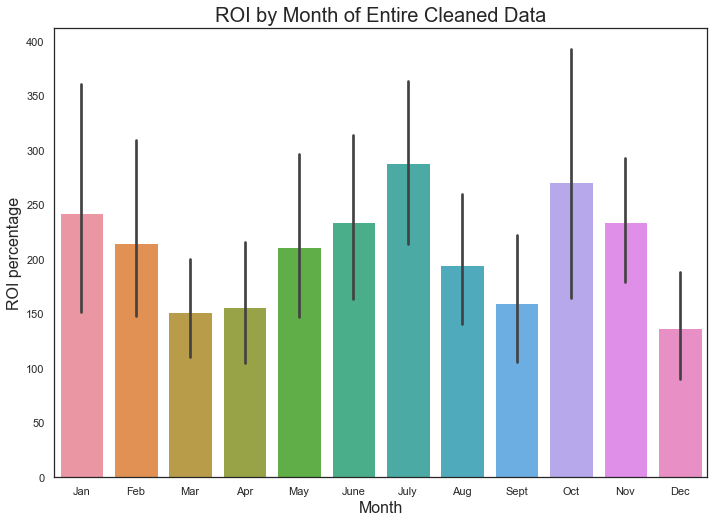

In [101]:
df = pd.DataFrame({'Month': Month,
                   'ROI': ROI,})
#set seaborn plotting aesthetics
sns.set(style='white')


ax = sns.barplot(x='Month', y='ROI',  data=df)
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax.set_ylabel('ROI percentage',fontsize = 16)
ax.set_xlabel('Month',fontsize = 16)
ax.set_title('ROI by Month of Entire Cleaned Data',fontsize = 20)
ax.set_xticklabels(month_list)
plt.savefig('fulldata_ROI_month.png', bbox_inches='tight');

This chart supports our assumption that July would be the best month to release a movie as even when adjusting for outliers, July still leads all months by ROI percentage.

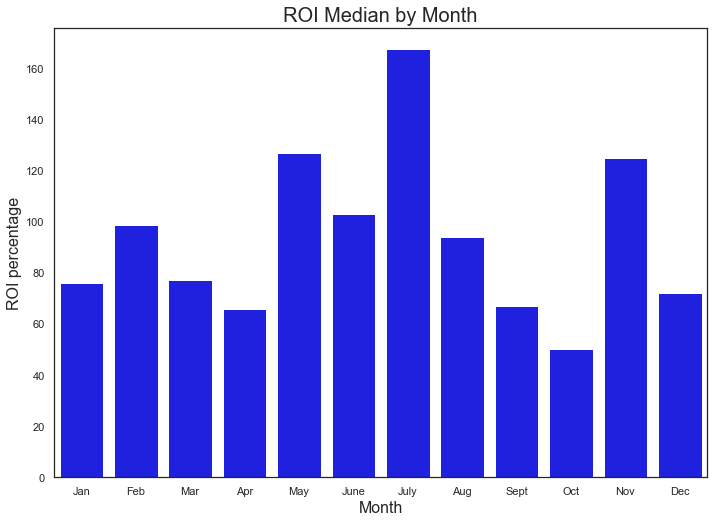

In [29]:
df2 = pd.DataFrame({'Month': month_median.keys(),
                   'ROI': month_median.values(),})
#set seaborn plotting aesthetics
sns.set(style='white')

#create grouped bar chart
ax = sns.barplot(x='Month', y='ROI',  data=df2, color='blue')
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax.set_ylabel('ROI percentage',fontsize = 16)
ax.set_xlabel('Month',fontsize = 16)
ax.set_title('ROI Median by Month',fontsize = 20)
plt.savefig('ROI_median_by_month.png', bbox_inches='tight');

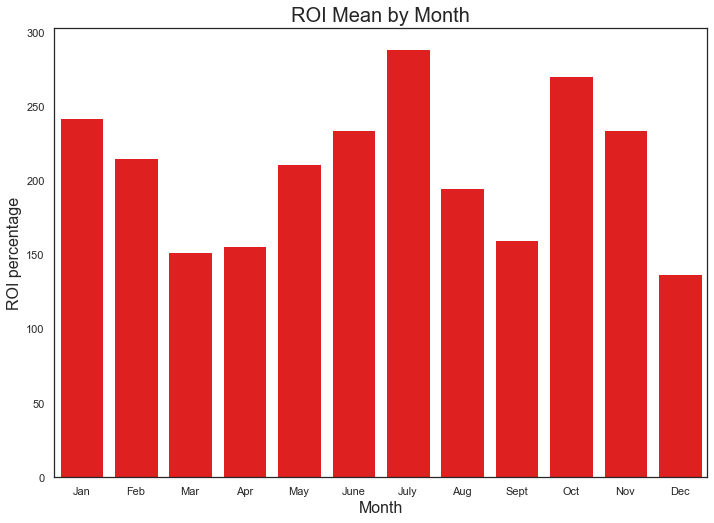

In [30]:
df1 = pd.DataFrame({'Month': month_mean.keys(),
                   'ROI': month_mean.values(),})
#set seaborn plotting aesthetics
sns.set(style='white')

#create grouped bar chart
ax = sns.barplot(x='Month', y='ROI',  data=df1,color='red')
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax.set_ylabel('ROI percentage',fontsize = 16)
ax.set_xlabel('Month',fontsize = 16)
ax.set_title('ROI Mean by Month',fontsize = 20)
plt.savefig('ROI_mean_by_month.png', bbox_inches='tight');

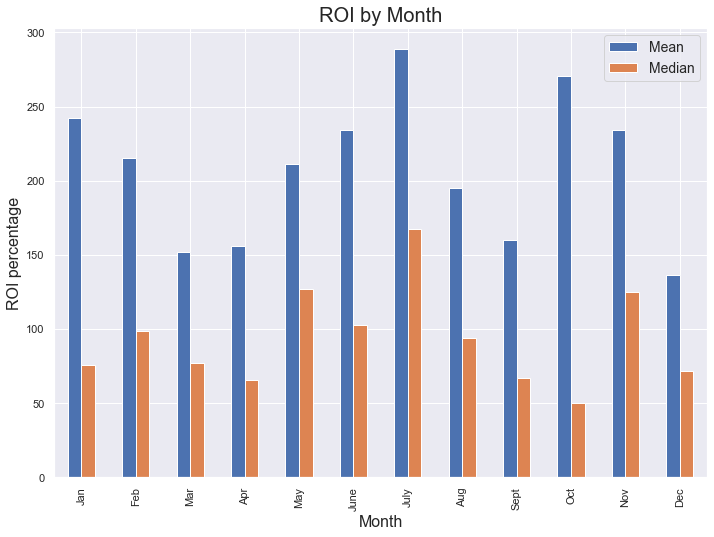

In [31]:
ax = pd.concat({
    'Mean': df1.set_index('Month'), 'Median': df2.set_index('Month'),
}, axis=1).plot.bar()
ax.set_ylabel('ROI percentage',fontsize = 16)
ax.set_xlabel('Month',fontsize = 16)
ax.set_title('ROI by Month',fontsize = 20)
plt.legend(labels=["Mean","Median"], fontsize = 14)
plt.savefig('ROI_combo_by_month', bbox_inches='tight');

# Recommendation 2: Analysis outcome 

Based on the different visualization trends we came to the conclusion that the best month of release would be July.

# IMDB Clean Up Process (Charles)

In [32]:
imdb_schema = pd.read_sql('''SELECT * FROM sqlite_master''',conn)
imdb_schema

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [33]:
writers_df = pd.read_sql('''select * from writers''', conn)
writers_df.head()
#writers kind of irrelevant for the question

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0438973,nm0175726
2,tt0438973,nm1802864
3,tt0462036,nm1940585
4,tt0835418,nm0310087


In [34]:
principals_df = pd.read_sql('''select * from principals''', conn)
principals_df.head()
#useful for actor/actresses,, probably drop characters, job since job = none but category has actor

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None
3,tt0323808,10,nm0059247,editor,None,None
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]"


In [35]:
principals_df['person_id'].value_counts()
#Tons of repeating names and whatnot

nm1930572     378
nm0000636     160
nm0000616     148
nm0103977     126
nm4394575     103
             ... 
nm5552005       1
nm10455150      1
nm8379330       1
nm7214068       1
nm8000953       1
Name: person_id, Length: 604546, dtype: int64

In [36]:
principals_df.info()
#Probably filter out characters since we want actors/actresses since jobs seems to be sparse

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028186 entries, 0 to 1028185
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   movie_id    1028186 non-null  object
 1   ordering    1028186 non-null  int64 
 2   person_id   1028186 non-null  object
 3   category    1028186 non-null  object
 4   job         177684 non-null   object
 5   characters  393360 non-null   object
dtypes: int64(1), object(5)
memory usage: 47.1+ MB


In [37]:
movie_basics_df = pd.read_sql('''select * from movie_basics''', conn)
movie_basics_df.head()
#Very useful, movie_Id common denominator

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [38]:
movie_basics_df.info()
#Lots of nulls in RunTime_Minutes, quite a few in Genres and some in Original Title
#Could probably drop original title while cleaning the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [39]:
movie_basics_df.describe()
#Max 2115? Probably have to put a max on the SQL query for it, same for runtime 

,start_year,runtime_minutes
count,146144.000000,114405.000000
mean,2014.621798,86.187247
std,2.733583,166.360590
min,2010.000000,1.000000
25%,2012.000000,70.000000
50%,2015.000000,87.000000
75%,2017.000000,99.000000
max,2115.000000,51420.000000


In [40]:
directors_df = pd.read_sql("""select * from directors""",conn)
directors_df.head()
#Merge off of movie_id to main database
#Convert person_ID through persons_df
#Usable, directors are nice

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502


In [41]:
writers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255873 entries, 0 to 255872
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   movie_id   255873 non-null  object
 1   person_id  255873 non-null  object
dtypes: object(2)
memory usage: 3.9+ MB


In [42]:
directors_df['person_id'].value_counts()
#Drop lower ones probably

nm6935209    238
nm2563700    190
nm1546474    185
nm3877467    180
nm3848412    144
            ... 
nm7410239      1
nm1151687      1
nm3835993      1
nm2011259      1
nm0225389      1
Name: person_id, Length: 109253, dtype: int64

In [43]:
directors_df.describe()
#nothing too relevant

,movie_id,person_id
count,291174,291174
unique,140417,109253
top,tt4050462,nm6935209
freq,3818,238


In [44]:
principals_df.describe()
#useless

,ordering
count,1.028186e+06
mean,4.739847e+00
std,2.747446e+00
min,1.000000e+00
25%,2.000000e+00
50%,4.000000e+00
75%,7.000000e+00
max,1.000000e+01


In [45]:
directors_df.info()
#complete data, nice

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291174 entries, 0 to 291173
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   movie_id   291174 non-null  object
 1   person_id  291174 non-null  object
dtypes: object(2)
memory usage: 4.4+ MB


In [46]:
known_for_df = pd.read_sql("""select * from known_for""",conn)
known_for_df.head()
#I dont really think this data set is relevant - dropping it
#Based off data it seems to just be a person (would have to merge to person_df) and what movie theyre known for

,person_id,movie_id
0,nm0061671,tt0837562
1,nm0061671,tt2398241
2,nm0061671,tt0844471
3,nm0061671,tt0118553
4,nm0061865,tt0896534


In [47]:
movie_akas_df = pd.read_sql("""select * from movie_akas""",conn)
movie_akas_df.head()
#Nothing too amazing, considering dropping this dataset

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0


In [48]:
movie_akas_df.info()
#Tons of nulls in language, type, and attributes; even region 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331703 entries, 0 to 331702
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   movie_id           331703 non-null  object 
 1   ordering           331703 non-null  int64  
 2   title              331703 non-null  object 
 3   region             278410 non-null  object 
 4   language           41715 non-null   object 
 5   types              168447 non-null  object 
 6   attributes         14925 non-null   object 
 7   is_original_title  331678 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 20.2+ MB


In [49]:
movie_akas_df.describe()
#Useless

,ordering,is_original_title
count,331703.000000,331678.000000
mean,5.125872,0.134769
std,6.706664,0.341477
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,6.000000,0.000000
max,61.000000,1.000000


In [50]:
movie_akas_df['movie_id'].value_counts()
#Tons of duplicates too based off movie id and how many regions released, probably irrelevant and too much information
#dropping this dataset too

tt2488496    61
tt1201607    55
tt2310332    55
tt2278871    53
tt1790809    53
             ..
tt1906327     1
tt1274639     1
tt2618224     1
tt2448756     1
tt7078492     1
Name: movie_id, Length: 122302, dtype: int64

In [51]:
movie_ratings_df = pd.read_sql("""select * from movie_ratings""",conn)
movie_ratings_df.head()
#Pretty useful information

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [52]:
movie_ratings_df.info()
#Full dataset, nice

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [53]:
round(movie_ratings_df.describe(),2)
#Rating scale looks clean, numvotes looks fine too since no negatives

,averagerating,numvotes
count,73856.00,73856.00
mean,6.33,3523.66
std,1.47,30294.02
min,1.00,5.00
25%,5.50,14.00
50%,6.50,49.00
75%,7.40,282.00
max,10.00,1841066.00


In [54]:
bug = movie_ratings_df.describe()

In [55]:
movie_ratings_df['movie_id'].value_counts()
#No dupes

tt10161248    1
tt6147514     1
tt2490326     1
tt4087850     1
tt1442625     1
             ..
tt3244320     1
tt1711525     1
tt5910262     1
tt1758607     1
tt3246212     1
Name: movie_id, Length: 73856, dtype: int64

In [56]:
persons_df = pd.read_sql("""select * from persons""",conn)
persons_df.head()
#Super useful for mapping person ID to primary names, rest of the information is a bit much
#Primary profession could be useful but can't be connected to actual movies since no movie_Id in dataset
#birth_year

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"


In [57]:
persons_df.describe()
#Probably remove dead people honestly

,birth_year,death_year
count,82736.000000,6783.000000
mean,1967.043826,2000.523367
std,22.122190,43.951530
min,1.000000,17.000000
25%,1957.000000,2001.000000
50%,1971.000000,2013.000000
75%,1981.000000,2016.000000
max,2014.000000,2019.000000


In [58]:
persons_df.info()
#Tons of null in birth year and death year

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   person_id           606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
dtypes: float64(2), object(3)
memory usage: 23.1+ MB


In [59]:
subdir = pd.read_sql(
'''
SELECT
    dir.movie_id,
    per.primary_name
FROM
    directors as dir
    LEFT JOIN persons as per
        ON dir.person_id = per.person_id
WHERE
    per.death_year is null
''',
conn
)
subdir.head()
#Filters out dead directors for movies 

,movie_id,primary_name
0,tt0285252,Tony Vitale
1,tt0462036,Bill Haley
2,tt0835418,Jay Chandrasekhar
3,tt0835418,Jay Chandrasekhar
4,tt0878654,Albert Pyun


In [60]:
subdir.shape

(289436, 2)

In [61]:
subpri = pd.read_sql(
'''
SELECT
    pri.movie_id,
    per.primary_name,
    pri.category
FROM
    principals as pri
    LEFT JOIN persons as per
        ON pri.person_id = per.person_id
WHERE
    (pri.category = 'actor'
    OR
    pri.category = 'actress'
    or
    pri.category = 'director')
    AND
    per.death_year is null
    AND
    per.primary_name is not null
''',
conn
)
subpri.head()
#Finding the actor/actresses, can be used to create a subquery
#director subquery potentially useless

,movie_id,primary_name,category
0,tt0111414,Tommy Dysart,actor
1,tt0111414,Frank Howson,director
2,tt0323808,Brittania Nicol,actress
3,tt0323808,Henry Garrett,actor
4,tt0323808,Graham McTavish,actor


In [62]:
subpri.shape
#Shapes huge 544k

(544661, 3)

In [63]:
subpri['category'].value_counts()
#Tons of actor, director, actress

actor       253619
director    145544
actress     145498
Name: category, dtype: int64

In [64]:
subpri.info()
#Complete data nice

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544661 entries, 0 to 544660
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   movie_id      544661 non-null  object
 1   primary_name  544661 non-null  object
 2   category      544661 non-null  object
dtypes: object(3)
memory usage: 12.5+ MB


In [65]:
imdb = pd.read_sql(
'''
SELECT
    mb.primary_title as MovieName,
    mb.start_year as StartYear,
    mb.runtime_minutes as RunTime,
    mb.genres as Genre,
    mr.averagerating as Rating,
    mr.numvotes as VoteCount   
FROM
    movie_basics as mb
    LEFT JOIN movie_ratings as mr
        ON mb.movie_id = mr.movie_id
WHERE
    mr.numvotes > 1000
    AND
    averagerating is not null
    AND
    start_year >= 2010
    and 
    runtime_minutes is not null
    and
    genres is not null 
''',
conn
)
imdb.head()
#overall imdb data, could be good for finding average ratings, genres, etc on whats good

,MovieName,StartYear,RunTime,Genre,Rating,VoteCount
0,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
1,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248
2,Dark Blood,2012,86.0,Thriller,6.6,1053
3,Wazir,2016,103.0,"Action,Crime,Drama",7.1,15378
4,The Wicker Tree,2011,96.0,"Drama,Horror",3.9,2328


In [66]:
imdb.shape
#9601 movies left

(9601, 6)

In [67]:
imdb.info()
#no nulls pog

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601 entries, 0 to 9600
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MovieName  9601 non-null   object 
 1   StartYear  9601 non-null   int64  
 2   RunTime    9601 non-null   float64
 3   Genre      9601 non-null   object 
 4   Rating     9601 non-null   float64
 5   VoteCount  9601 non-null   int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 450.2+ KB


In [68]:
imdb2 = imdb
#creating a new dataframe to not mess with the original

In [69]:
imdb2['Genre'] = imdb['Genre'].str.split(',')
#String splitting genre for exploding purposes

In [70]:
imdb2.head(5)
#check it

,MovieName,StartYear,RunTime,Genre,Rating,VoteCount
0,The Other Side of the Wind,2018,122.0,[Drama],6.9,4517
1,Foodfight!,2012,91.0,"[Action, Animation, Comedy]",1.9,8248
2,Dark Blood,2012,86.0,[Thriller],6.6,1053
3,Wazir,2016,103.0,"[Action, Crime, Drama]",7.1,15378
4,The Wicker Tree,2011,96.0,"[Drama, Horror]",3.9,2328


In [71]:
imdb2['StartYear'].value_counts()
#Checking range of years for data, 2010 to 2019

2014    1187
2015    1126
2016    1114
2013    1102
2017    1086
2012    1041
2011     983
2010     924
2018     857
2019     181
Name: StartYear, dtype: int64

In [72]:
imdbexp = imdb2.explode('Genre')
#explode to separate all the genres

In [73]:
imdbexp.head(5)
#check it

,MovieName,StartYear,RunTime,Genre,Rating,VoteCount
0,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
1,Foodfight!,2012,91.0,Action,1.9,8248
1,Foodfight!,2012,91.0,Animation,1.9,8248
1,Foodfight!,2012,91.0,Comedy,1.9,8248
2,Dark Blood,2012,86.0,Thriller,6.6,1053


In [74]:
imdbexp.info()
#no nulls nice

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21780 entries, 0 to 9600
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MovieName  21780 non-null  object 
 1   StartYear  21780 non-null  int64  
 2   RunTime    21780 non-null  float64
 3   Genre      21780 non-null  object 
 4   Rating     21780 non-null  float64
 5   VoteCount  21780 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 1.2+ MB


In [75]:
imdb_work = pd.read_sql(
'''
SELECT
    mb.start_year as MovieYear,
    mb.primary_title as MovieName,
    mr.averagerating as AvgRating,
    job.primary_name as Name,
    job.category as Job
FROM
    (SELECT
        pri.movie_id,
        per.primary_name,
        pri.category
            FROM
        principals as pri
            LEFT JOIN persons as per
            ON pri.person_id = per.person_id
    WHERE
        (pri.category = 'actor'
        OR
        pri.category = 'actress'
        or
        pri.category = 'director')
        AND
        per.death_year is null
        AND
        per.primary_name is not null) as job
    LEFT JOIN movie_basics as mb
        ON job.movie_id = mb.movie_id
    LEFT JOIN movie_ratings as mr
        on job.movie_id = mr.movie_id
WHERE
    mr.numvotes > 1000
    AND
    averagerating is not null
    AND
    start_year >= 2010
    and 
    runtime_minutes is not null
    and
    genres is not null
ORDER BY
    job.primary_name,
    mb.start_year
''',
conn
)
imdb_work.head(10)
#This ensures actors or actresses with more than enough experience on an average rating
#this is only for names

,MovieYear,MovieName,AvgRating,Name,Job
0,2010,Caught in the Crossfire,4.5,50 Cent,actor
1,2010,Gun,3.8,50 Cent,actor
2,2011,All Things Fall Apart,5.5,50 Cent,actor
3,2011,Setup,4.4,50 Cent,actor
4,2012,Freelancers,4.6,50 Cent,actor
5,2013,Escape Plan,6.7,50 Cent,actor
6,2018,Den of Thieves,7.0,50 Cent,actor
7,2010,Darling,7.3,A. Karunakaran,director
8,2016,Phantasm: Ravager,5.1,A. Michael Baldwin,actor
9,2015,Ask Sana Benzer,3.8,A. Taner Elhan,director


In [76]:
imdb_work.loc[imdb_work['Name'] == '50 Cent']['MovieYear'].corr(imdb_work.loc[imdb_work['Name'] == '50 Cent']['AvgRating'])
#testing code for correlation

0.8258218959300295

In [77]:
imdb_names = pd.read_sql(
'''
SELECT
    job.primary_name as Name,
    job.category as Job,
    AVG(mr.averagerating) as Rating
FROM
    (SELECT
        pri.movie_id,
        per.primary_name,
        pri.category
            FROM
        principals as pri
            LEFT JOIN persons as per
            ON pri.person_id = per.person_id
    WHERE
        (pri.category = 'actor'
        OR
        pri.category = 'actress'
        or
        pri.category = 'director')
        AND
        per.death_year is null
        AND
        per.primary_name is not null) as job
    LEFT JOIN movie_basics as mb
        ON job.movie_id = mb.movie_id
    LEFT JOIN movie_ratings as mr
        on job.movie_id = mr.movie_id
WHERE
    mr.numvotes > 1000
    AND
    averagerating is not null
    AND
    start_year >= 2010
    and 
    runtime_minutes is not null
    and
    genres is not null
GROUP BY
    job.primary_name
HAVING
    count(mr.averagerating) > 5
ORDER BY
    AVG(mr.averagerating) DESC
''',
conn
)
imdb_names.head()
#This ensures actors or actresses with more than enough experience on an average rating
#this is only for names

,Name,Job,Rating
0,Leonardo DiCaprio,actor,8.088889
1,Radha Ravi,actor,7.983333
2,Vijay Sethupathi,actor,7.847059
3,Fahadh Faasil,actor,7.837500
4,Martin Scorsese,director,7.816667


In [78]:
imdb_names.head(2)

,Name,Job,Rating
0,Leonardo DiCaprio,actor,8.088889
1,Radha Ravi,actor,7.983333


In [79]:
imdb_actors = imdb_names.loc[imdb_names['Job']=='actor'].reset_index(drop=True)
imdb_actors.head(2) #Actors only

,Name,Job,Rating
0,Leonardo DiCaprio,actor,8.088889
1,Radha Ravi,actor,7.983333


In [80]:
actors_corr = pd.DataFrame({'Correlation':[imdb_work.loc[imdb_work['Name'] == actor]['MovieYear'].corr(imdb_work.loc[imdb_work['Name'] == actor]['AvgRating']) for actor in imdb_actors['Name']]})
#creating correlation series for the actors with prior code

In [81]:
imdb_actors['Correlation'] = actors_corr
imdb_actors.head(2)
#adding correlation to it

,Name,Job,Rating,Correlation
0,Leonardo DiCaprio,actor,8.088889,0.534253
1,Radha Ravi,actor,7.983333,0.324168


In [82]:
imdb_actors.info() #nice

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         754 non-null    object 
 1   Job          754 non-null    object 
 2   Rating       754 non-null    float64
 3   Correlation  754 non-null    float64
dtypes: float64(2), object(2)
memory usage: 23.7+ KB


In [83]:
imdb_actress = imdb_names.loc[imdb_names['Job']=='actress'].reset_index(drop=True)
imdb_actress.head(2) #Actress only

,Name,Job,Rating
0,Parvathy,actress,7.666667
1,Aoi Yûki,actress,7.600000


In [84]:
actress_corr = pd.DataFrame({'Correlation':[imdb_work.loc[imdb_work['Name'] == actress]['MovieYear'].corr(imdb_work.loc[imdb_work['Name'] == actress]['AvgRating']) for actress in imdb_actress['Name']]})
actress_corr.head(2) #Correlation for females

,Correlation
0,0.146313
1,0.073603


In [85]:
imdb_actress['Correlation'] = actress_corr
#Adding the correlation column to imdb actress

In [86]:
imdb_actress.head(2) #Checking new data with corr

,Name,Job,Rating,Correlation
0,Parvathy,actress,7.666667,0.146313
1,Aoi Yûki,actress,7.600000,0.073603


In [87]:
imdb_actress.info() #All is well

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         381 non-null    object 
 1   Job          381 non-null    object 
 2   Rating       381 non-null    float64
 3   Correlation  381 non-null    float64
dtypes: float64(2), object(2)
memory usage: 12.0+ KB


In [88]:
imdb_director = imdb_names.loc[imdb_names['Job']=='director'].reset_index(drop=True)
imdb_director.head(10) #Director

,Name,Job,Rating
0,Martin Scorsese,director,7.816667
1,Denis Villeneuve,director,7.800000
2,Dileesh Pothan,director,7.733333
3,Hirokazu Koreeda,director,7.466667
4,Akiyuki Shinbo,director,7.383333
5,Saurabh Shukla,director,7.333333
6,Alex Gibney,director,7.309091
7,Srijit Mukherji,director,7.262500
8,Steven Spielberg,director,7.228571
9,James Wan,director,7.116667


In [89]:
director_corr = pd.DataFrame({'Correlation':[imdb_work.loc[imdb_work['Name'] == director]['MovieYear'].corr(imdb_work.loc[imdb_work['Name'] == director]['AvgRating']) for director in imdb_director['Name']]})
director_corr.head(2)  #Creating correlation for directors now

,Correlation
0,-0.514463
1,-0.127000


In [90]:
imdb_director['Correlation'] = director_corr #putting the correlation into the directors

In [91]:
imdb_director.head(2) #All is well

,Name,Job,Rating,Correlation
0,Martin Scorsese,director,7.816667,-0.514463
1,Denis Villeneuve,director,7.800000,-0.127000


In [92]:
imdb_director.info() #All is well, only 85 directors weird

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         85 non-null     object 
 1   Job          85 non-null     object 
 2   Rating       85 non-null     float64
 3   Correlation  85 non-null     float64
dtypes: float64(2), object(2)
memory usage: 2.8+ KB


Text(0, 0.5, 'Correlation of Movie Rating from 2010-2019')

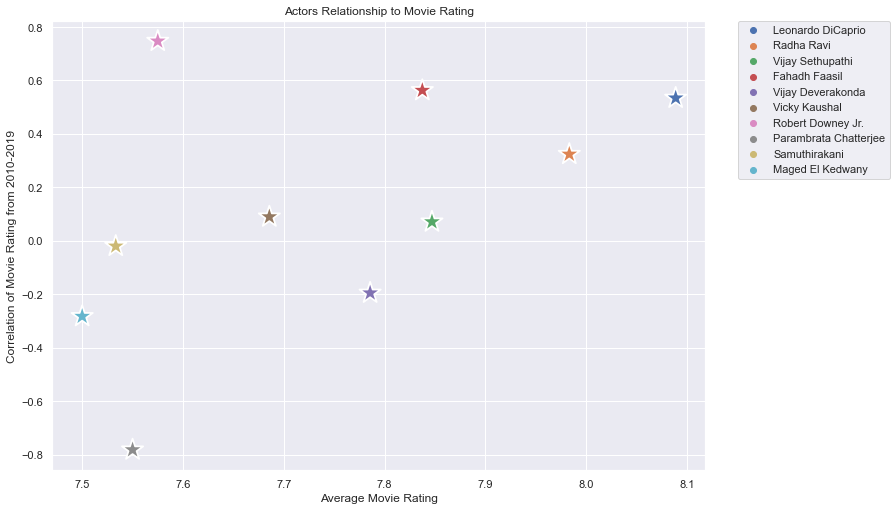

In [93]:
scatact = sns.scatterplot(x='Rating',y='Correlation',hue='Name',data=imdb_actors.head(10), marker = '*', s=500)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Actors Relationship to Movie Rating')
plt.xlabel('Average Movie Rating')
plt.ylabel('Correlation of Movie Rating from 2010-2019')
#Chart for actor correlation and average movie rating from 2010 to 2019

Text(0, 0.5, 'Correlation of Movie Rating from 2010-2019')

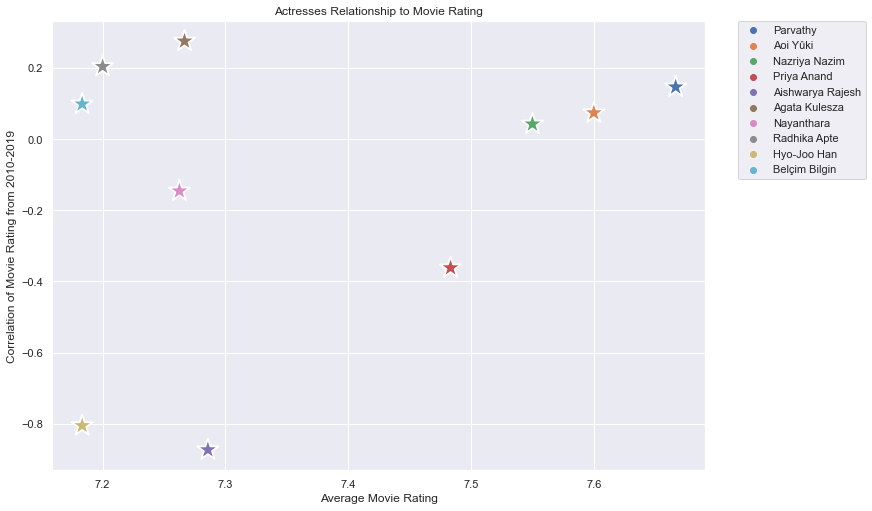

In [94]:
scatact = sns.scatterplot(x='Rating',y='Correlation',hue='Name',data=imdb_actress.head(10), marker = '*', s=500)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Actresses Relationship to Movie Rating')
plt.xlabel('Average Movie Rating')
plt.ylabel('Correlation of Movie Rating from 2010-2019')
#Chart for actress correlation and average movie rating from 2010 to 2019

Text(0, 0.5, 'Correlation of Movie Rating from 2010-2019')

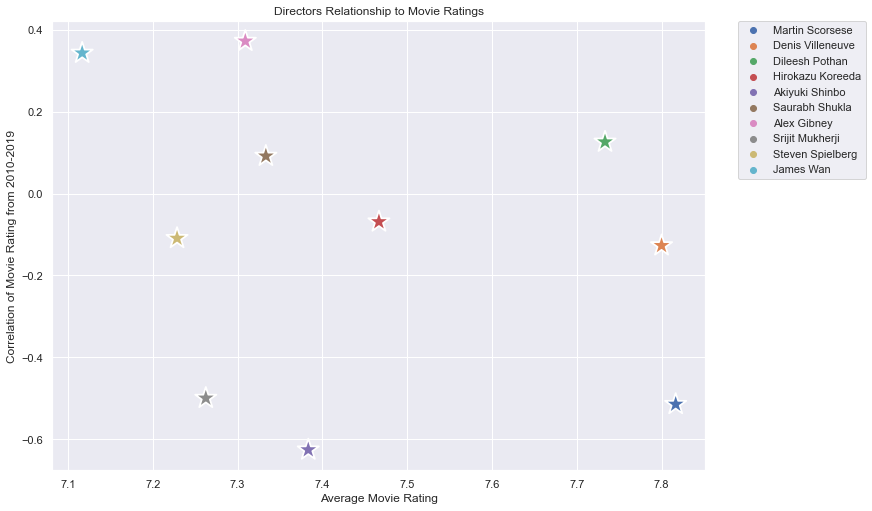

In [95]:
scatdir = sns.scatterplot(x='Rating',y='Correlation',hue='Name',data=imdb_director.head(10), marker = '*', s=500)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Directors Relationship to Movie Ratings')
plt.xlabel('Average Movie Rating')
plt.ylabel('Correlation of Movie Rating from 2010-2019')
#Chart for director correlation and average movie rating from 2010 to 2019

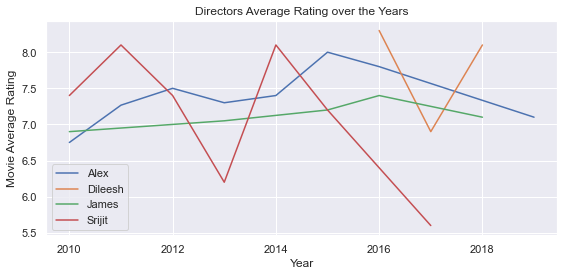

In [96]:
alexgibney = imdb_work.loc[imdb_work['Name']=='Alex Gibney'].groupby('MovieYear').mean()
dileeshpothan = imdb_work.loc[imdb_work['Name']=='Dileesh Pothan'].groupby('MovieYear').mean()
jameswan = imdb_work.loc[imdb_work['Name']=='James Wan'].groupby('MovieYear').mean()
srijitmukherji = imdb_work.loc[imdb_work['Name']=='Srijit Mukherji'].groupby('MovieYear').mean()
#Setting up infrastructure for the chart
#Used to groupby and average out movie ratings from the same year
x = np.linspace(0, 10, 1000)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(alexgibney.index.values, 'AvgRating', data=alexgibney, label='Alex')
ax.plot(dileeshpothan.index.values, 'AvgRating', data=dileeshpothan, label='Dileesh')
ax.plot(jameswan.index.values, 'AvgRating', data=jameswan, label='James')
ax.plot(srijitmukherji.index.values, 'AvgRating', data=srijitmukherji, label='Srijit')
ax.set_xlabel('Year')
ax.set_ylabel('Movie Average Rating')
ax.set_title('Directors Average Rating over the Years')
plt.tight_layout()
leg = ax.legend();
#Line chart for directors, recommend Alex, James, Dileesh; Srijit is an example of bad correlation

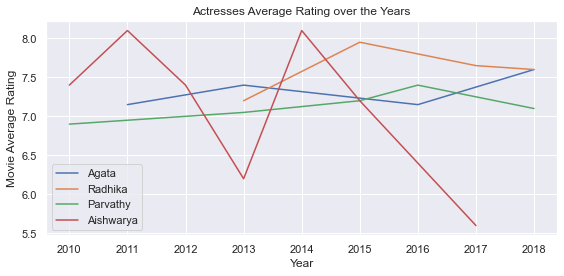

In [97]:
agatakulesza = imdb_work.loc[imdb_work['Name']=='Agata Kulesza'].groupby('MovieYear').mean()
radhikaapte = imdb_work.loc[imdb_work['Name']=='Parvathy'].groupby('MovieYear').mean()
parvathy = imdb_work.loc[imdb_work['Name']=='James Wan'].groupby('MovieYear').mean()
aishwaryarajesh = imdb_work.loc[imdb_work['Name']=='Srijit Mukherji'].groupby('MovieYear').mean()
#Setting up infrastructure for the chart
#Used to groupby and average out movie ratings from the same year
x = np.linspace(0, 10, 1000)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(agatakulesza.index.values, 'AvgRating', data=agatakulesza, label='Agata')
ax.plot(radhikaapte.index.values, 'AvgRating', data=radhikaapte, label='Radhika')
ax.plot(parvathy.index.values, 'AvgRating', data=parvathy, label='Parvathy')
ax.plot(aishwaryarajesh.index.values, 'AvgRating', data=aishwaryarajesh, label='Aishwarya')
ax.set_xlabel('Year')
ax.set_ylabel('Movie Average Rating')
ax.set_title('Actresses Average Rating over the Years')
plt.tight_layout()
leg = ax.legend();
#Line chart for actress, recommend Agata, Radhika, Parvath; Aishwaryara is an example of bad correlation

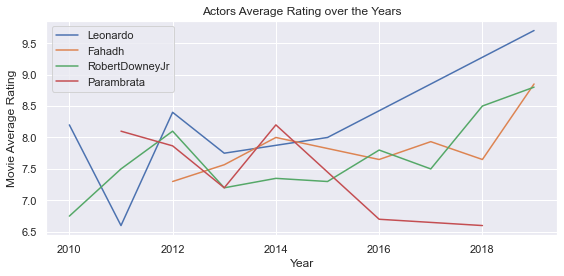

In [98]:
leonardodicaprio = imdb_work.loc[imdb_work['Name']=='Leonardo DiCaprio'].groupby('MovieYear').mean()
fahadhfaasil = imdb_work.loc[imdb_work['Name']=='Fahadh Faasil'].groupby('MovieYear').mean()
robertdowneyjr = imdb_work.loc[imdb_work['Name']=='Robert Downey Jr.'].groupby('MovieYear').mean()
parambratachatterjee = imdb_work.loc[imdb_work['Name']=='Parambrata Chatterjee'].groupby('MovieYear').mean()
#Setting up infrastructure for the chart
#Used to groupby and average out movie ratings from the same year
x = np.linspace(0, 10, 1000)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(leonardodicaprio.index.values, 'AvgRating', data=leonardodicaprio, label='Leonardo')
ax.plot(fahadhfaasil.index.values, 'AvgRating', data=fahadhfaasil, label='Fahadh')
ax.plot(robertdowneyjr.index.values, 'AvgRating', data=robertdowneyjr, label='RobertDowneyJr')
ax.plot(parambratachatterjee.index.values, 'AvgRating', data=parambratachatterjee, label='Parambrata')
ax.set_xlabel('Year')
ax.set_ylabel('Movie Average Rating')
ax.set_title('Actors Average Rating over the Years')
plt.tight_layout()
leg = ax.legend();
#Line chart for actress, recommend Leonardo, Fahadh, RobertDowneyJr; Parambrata is an example of bad correlation

# Recommendation 2: Analysis outcome 

In [99]:
# Recommendation 2: Analysis outcome # # Recommendation 3: Analysis outcome 